In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/AML

/content/drive/MyDrive/AML


In [4]:
#  ---------- Data Preprocessing -------------
# Read the data from csv
X, y = pd.read_csv('task-1-brain-age-prediction/X_train.csv'), pd.read_csv('task-1-brain-age-prediction/y_train.csv')

# drop the id column, useless for training
X.drop(labels='id', axis=1, inplace=True)
y.drop(labels='id', axis=1, inplace=True)

In [5]:
# Stage 1 :: Data Imputation --> KNNImputer
from sklearn.impute import KNNImputer

X_index, X_columns = X.index, X.columns
knn_impute = KNNImputer(n_neighbors=10, weights='distance')
X = knn_impute.fit_transform(X)

In [6]:
X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [7]:
print(X.shape)
X = X.drop_duplicates()
print(X.shape)

(1212, 832)
(1212, 832)


In [8]:
# Stage 2: Feature selection --> Remove columns with zero variance
mask_ = X.var(axis=0) != 0
X = X.loc[:, mask_]
print(X.shape)

(1212, 828)


In [9]:
print(X.isnull().sum().sum()) # check imputer

0


In [10]:
# Load X_test only for visualisation purposes
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test.drop(labels='id', axis=1, inplace=True)
X_test = knn_impute.transform(X_test)
#X_test.fillna(X_median, axis=0, inplace=True)

X_test = X_test[:, mask_]

In [11]:
from sklearn.preprocessing import QuantileTransformer

qtr = QuantileTransformer(n_quantiles=X.shape[0], output_distribution='normal')
X_scaled = qtr.fit_transform(X)
X_test_scaled = qtr.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


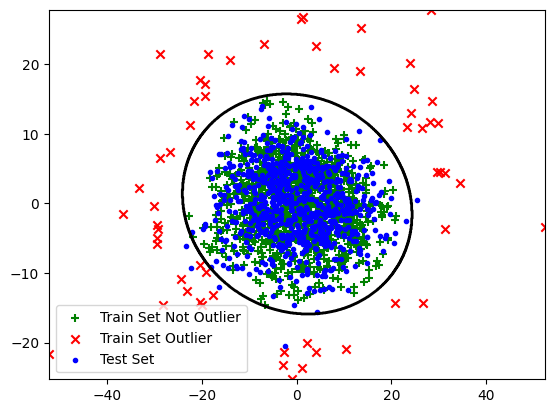

In [12]:
# Stage 3 :: Outlier Detection
# Some motivation for this approach --> since we're trying to maximize
# r2 score on the test set and we don't have the gt label for the test set
# we only have to consider the points int the training set that are in accordance with
# the points in the test set, i.e the outliers are the points which are far of the elliptic
# envelope decision boundary

from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

fig, ax = plt.subplots()

pca = PCA(n_components=2)
X_project = pca.fit_transform(X_scaled)
X_test_project = pca.transform(X_test_scaled)

ax.set_xlim(left=X_project[:, 0].min(), right=X_project[:, 0].max())
ax.set_ylim(bottom=X_project[:, 1].min(), top=X_project[:, 1].max())

# Outlier analysis --> EllipticEnvelope (Gaussian)
xx, yy = np.meshgrid(np.linspace(X_project[:, 0].min(), \
X_project[:, 0].max(), 1000), np.linspace(X_project[:, 1].min(), \
    X_project[:, 1].max(), 1000))

elliptic = EllipticEnvelope(contamination=0.047)
outliers = elliptic.fit_predict(X_project)
mask_outliers_out = outliers != -1
X_project_not_outliers = X_project[mask_outliers_out, :]
X_project_outliers = X_project[~mask_outliers_out, :]

ax.scatter(X_project_not_outliers[:, 0], X_project_not_outliers[:, 1], marker='+', color='green')
ax.scatter(X_project_outliers[:, 0], X_project_outliers[:, 1], marker='x', color='red')
ax.scatter(X_test_project[:, 0], X_test_project[:, 1], marker='.', color='blue')
Z = elliptic.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
ax.legend(['Train Set Not Outlier', 'Train Set Outlier', 'Test Set'])

plt.show()

del X_project
del X_test_project
# we don't need the scaled version of X so delete it
del X_scaled
del X_test_scaled

In [13]:
print(mask_outliers_out.sum())

1155


In [14]:
print(X.shape[0])

1212


In [15]:
# Outlier removal
X = X.loc[mask_outliers_out, :]
y = y.loc[mask_outliers_out, :]

In [16]:
# now we need to go through quantile transformation again
qtr = QuantileTransformer(n_quantiles=X.shape[0], output_distribution='normal')
# checkpoint for pandas
X_index, X_columns = X.index, X.columns
# fit qtr and transform yet again
X = qtr.fit_transform(X)
# back to pandas
X = pd.DataFrame(X, index=X_index, columns=X_columns)

# from sklearn.preprocessing import RobustScaler

# rbc = RobustScaler()
# X_index, X_columns = X.index, X.columns
# X = rbc.fit_transform(X)
# X = pd.DataFrame(X, index=X_index, columns=X_columns)

In [17]:
# Feature Selection :: Here based on mutual information score
# from sklearn.feature_selection import mutual_info_regression
# mutual_info_w_target = mutual_info_regression(X, y.squeeze())
# X = X.loc[:, mutual_info_w_target > 0.1]

# Feature Selection :: Here based on highest correlation
# compute the feature_corr
print(f'Shape before feature selection (X_train//X_test) is {(X.shape)}')
feature_corr = X.corrwith(y.squeeze()).abs() > 0.2
X = X.loc[:, feature_corr]
print(f'Shape after feature selection (X_train//X_test) is {(X.shape)}')

Shape before feature selection (X_train//X_test) is (1155, 828)
Shape after feature selection (X_train//X_test) is (1155, 150)


In [18]:
X.shape

(1155, 150)

In [18]:
# Empirically the more features, the higher generalisation, so we would only need to
# remove the highly correlated features
def filter_multicolinearity(X_train, sigma):
    corr_matrix = np.triu(np.corrcoef(X_train, rowvar=False))
    np.fill_diagonal(corr_matrix, val=0)
    mask_multicorr = (corr_matrix < sigma).all(axis=1)
    return mask_multicorr
mask_multicorr = filter_multicolinearity(X, 0.9)
X = X.loc[:, mask_multicorr]

In [20]:
X.shape

(1155, 137)

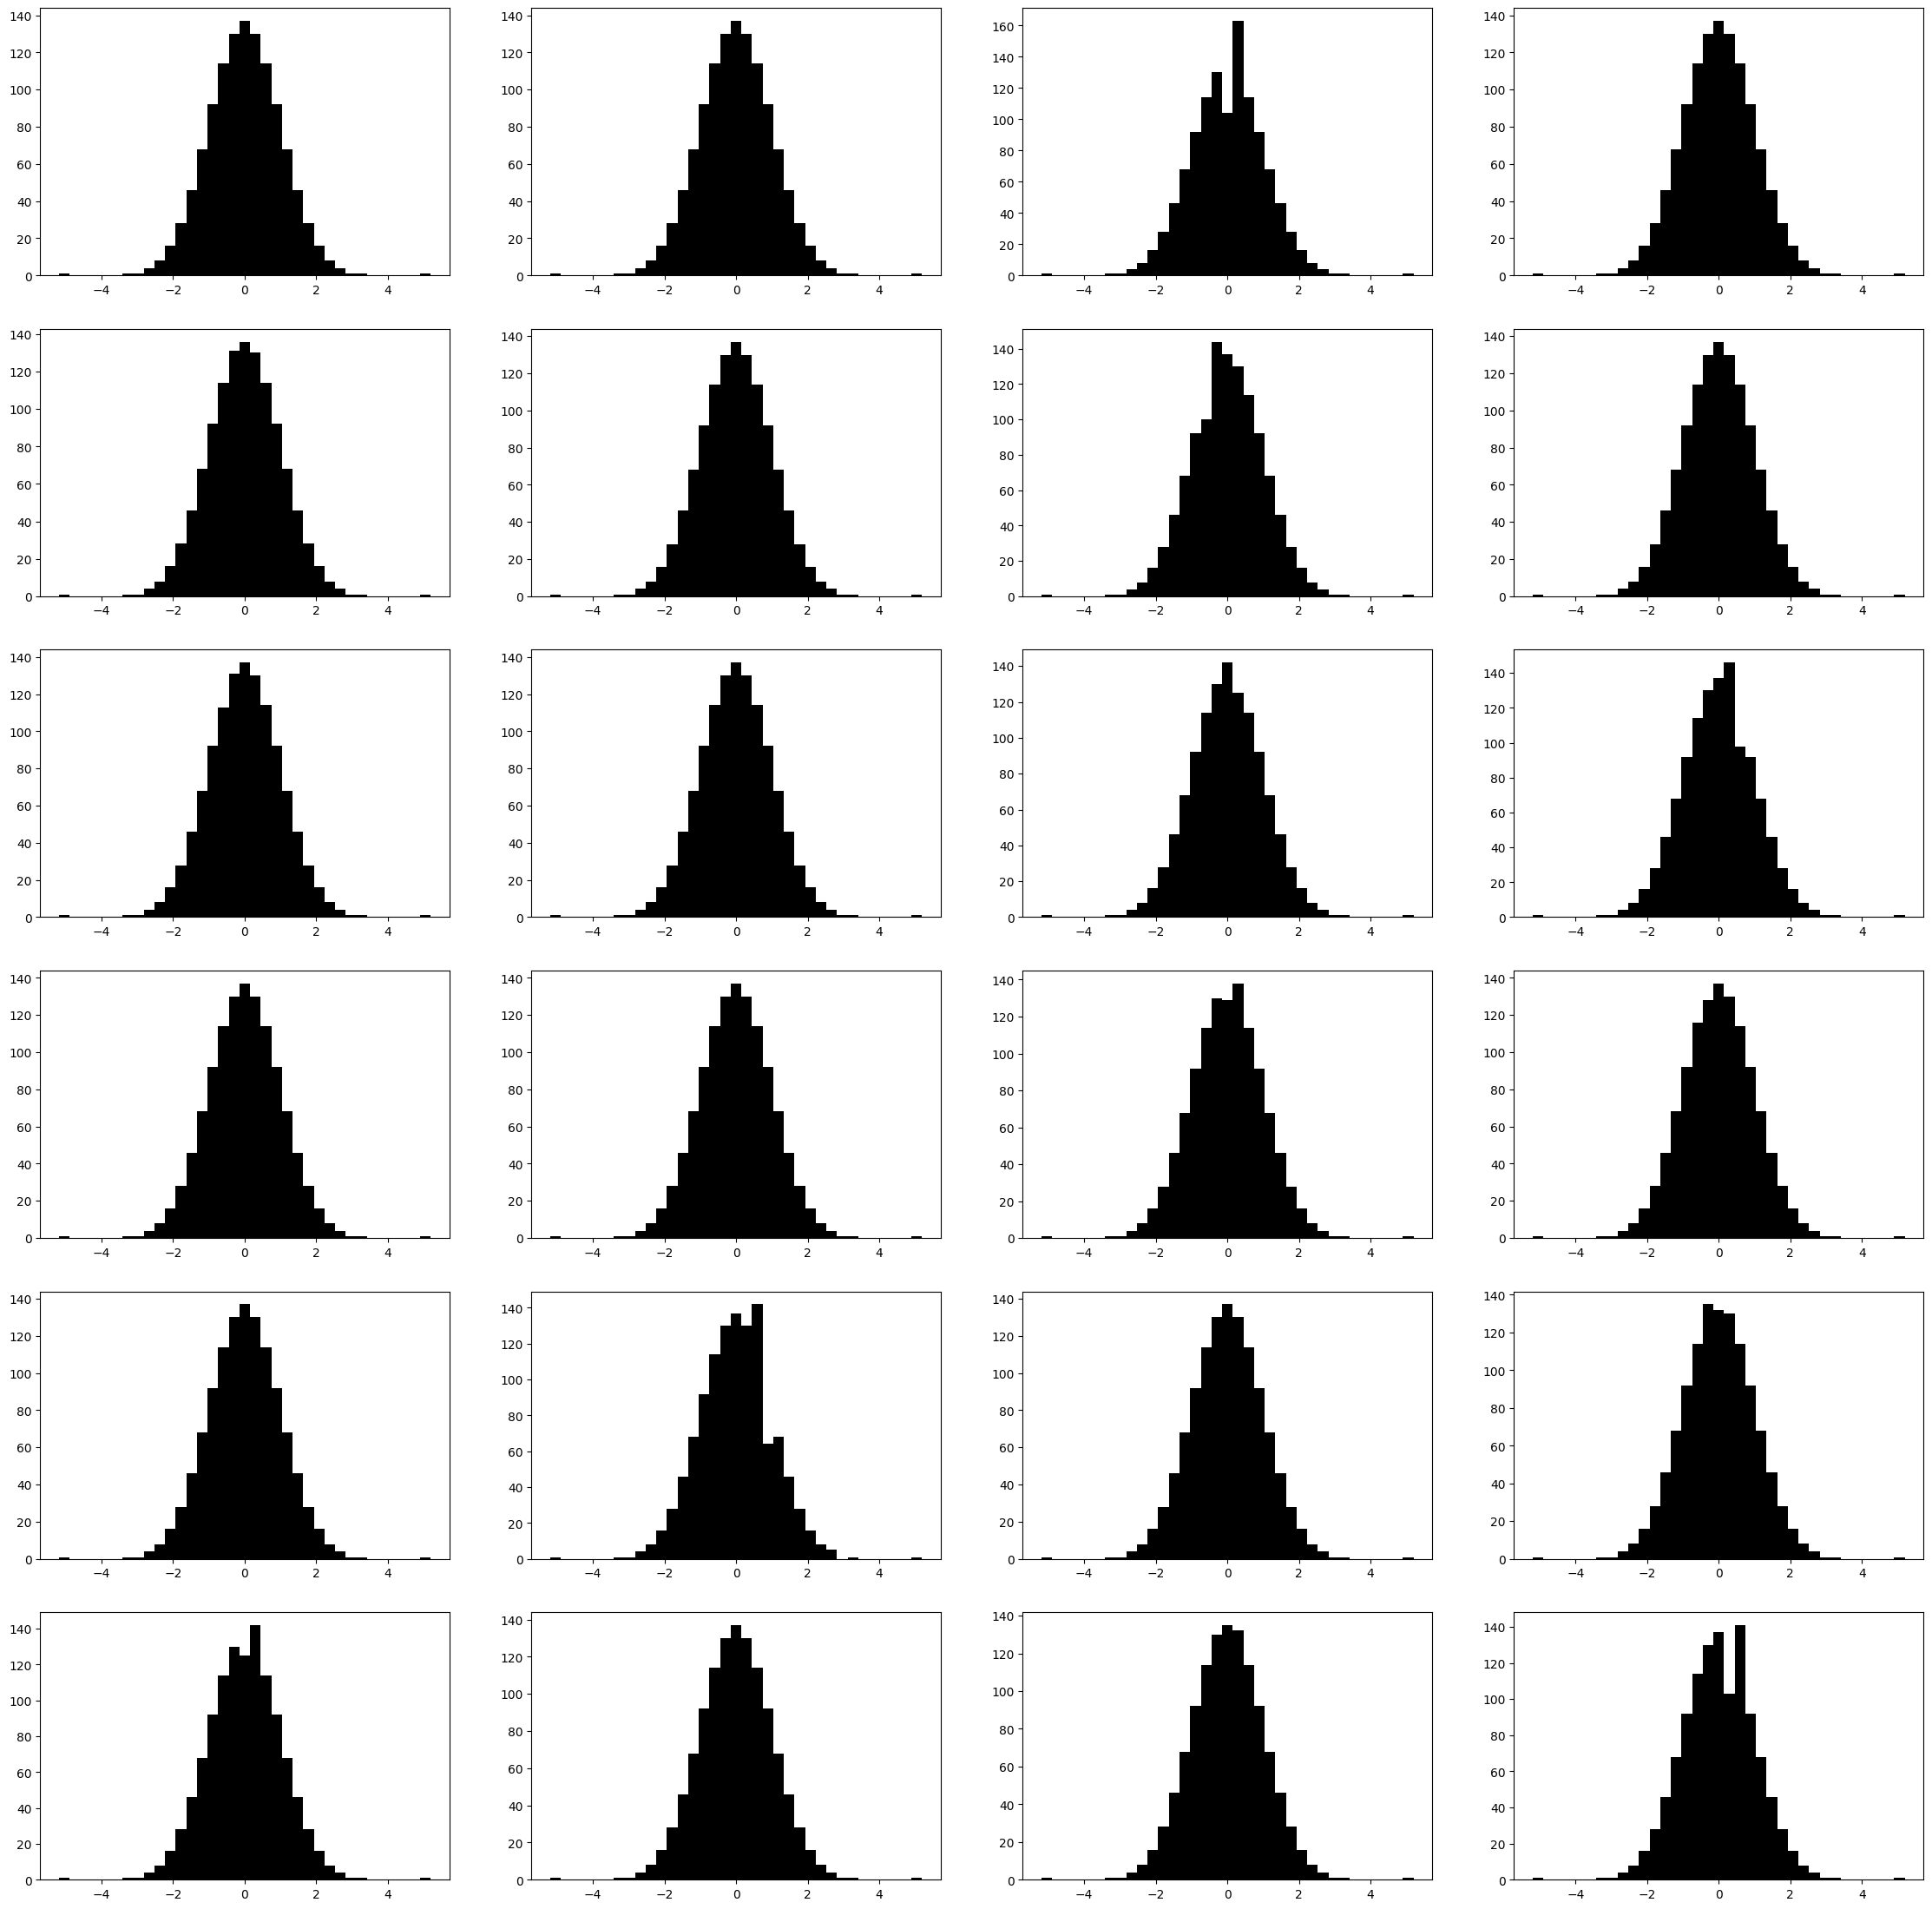

In [19]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(28, 28))

for i in range(24):
    ax[i // 4, i % 4].hist(X.iloc[:, i], bins=35, color='black')
plt.show()

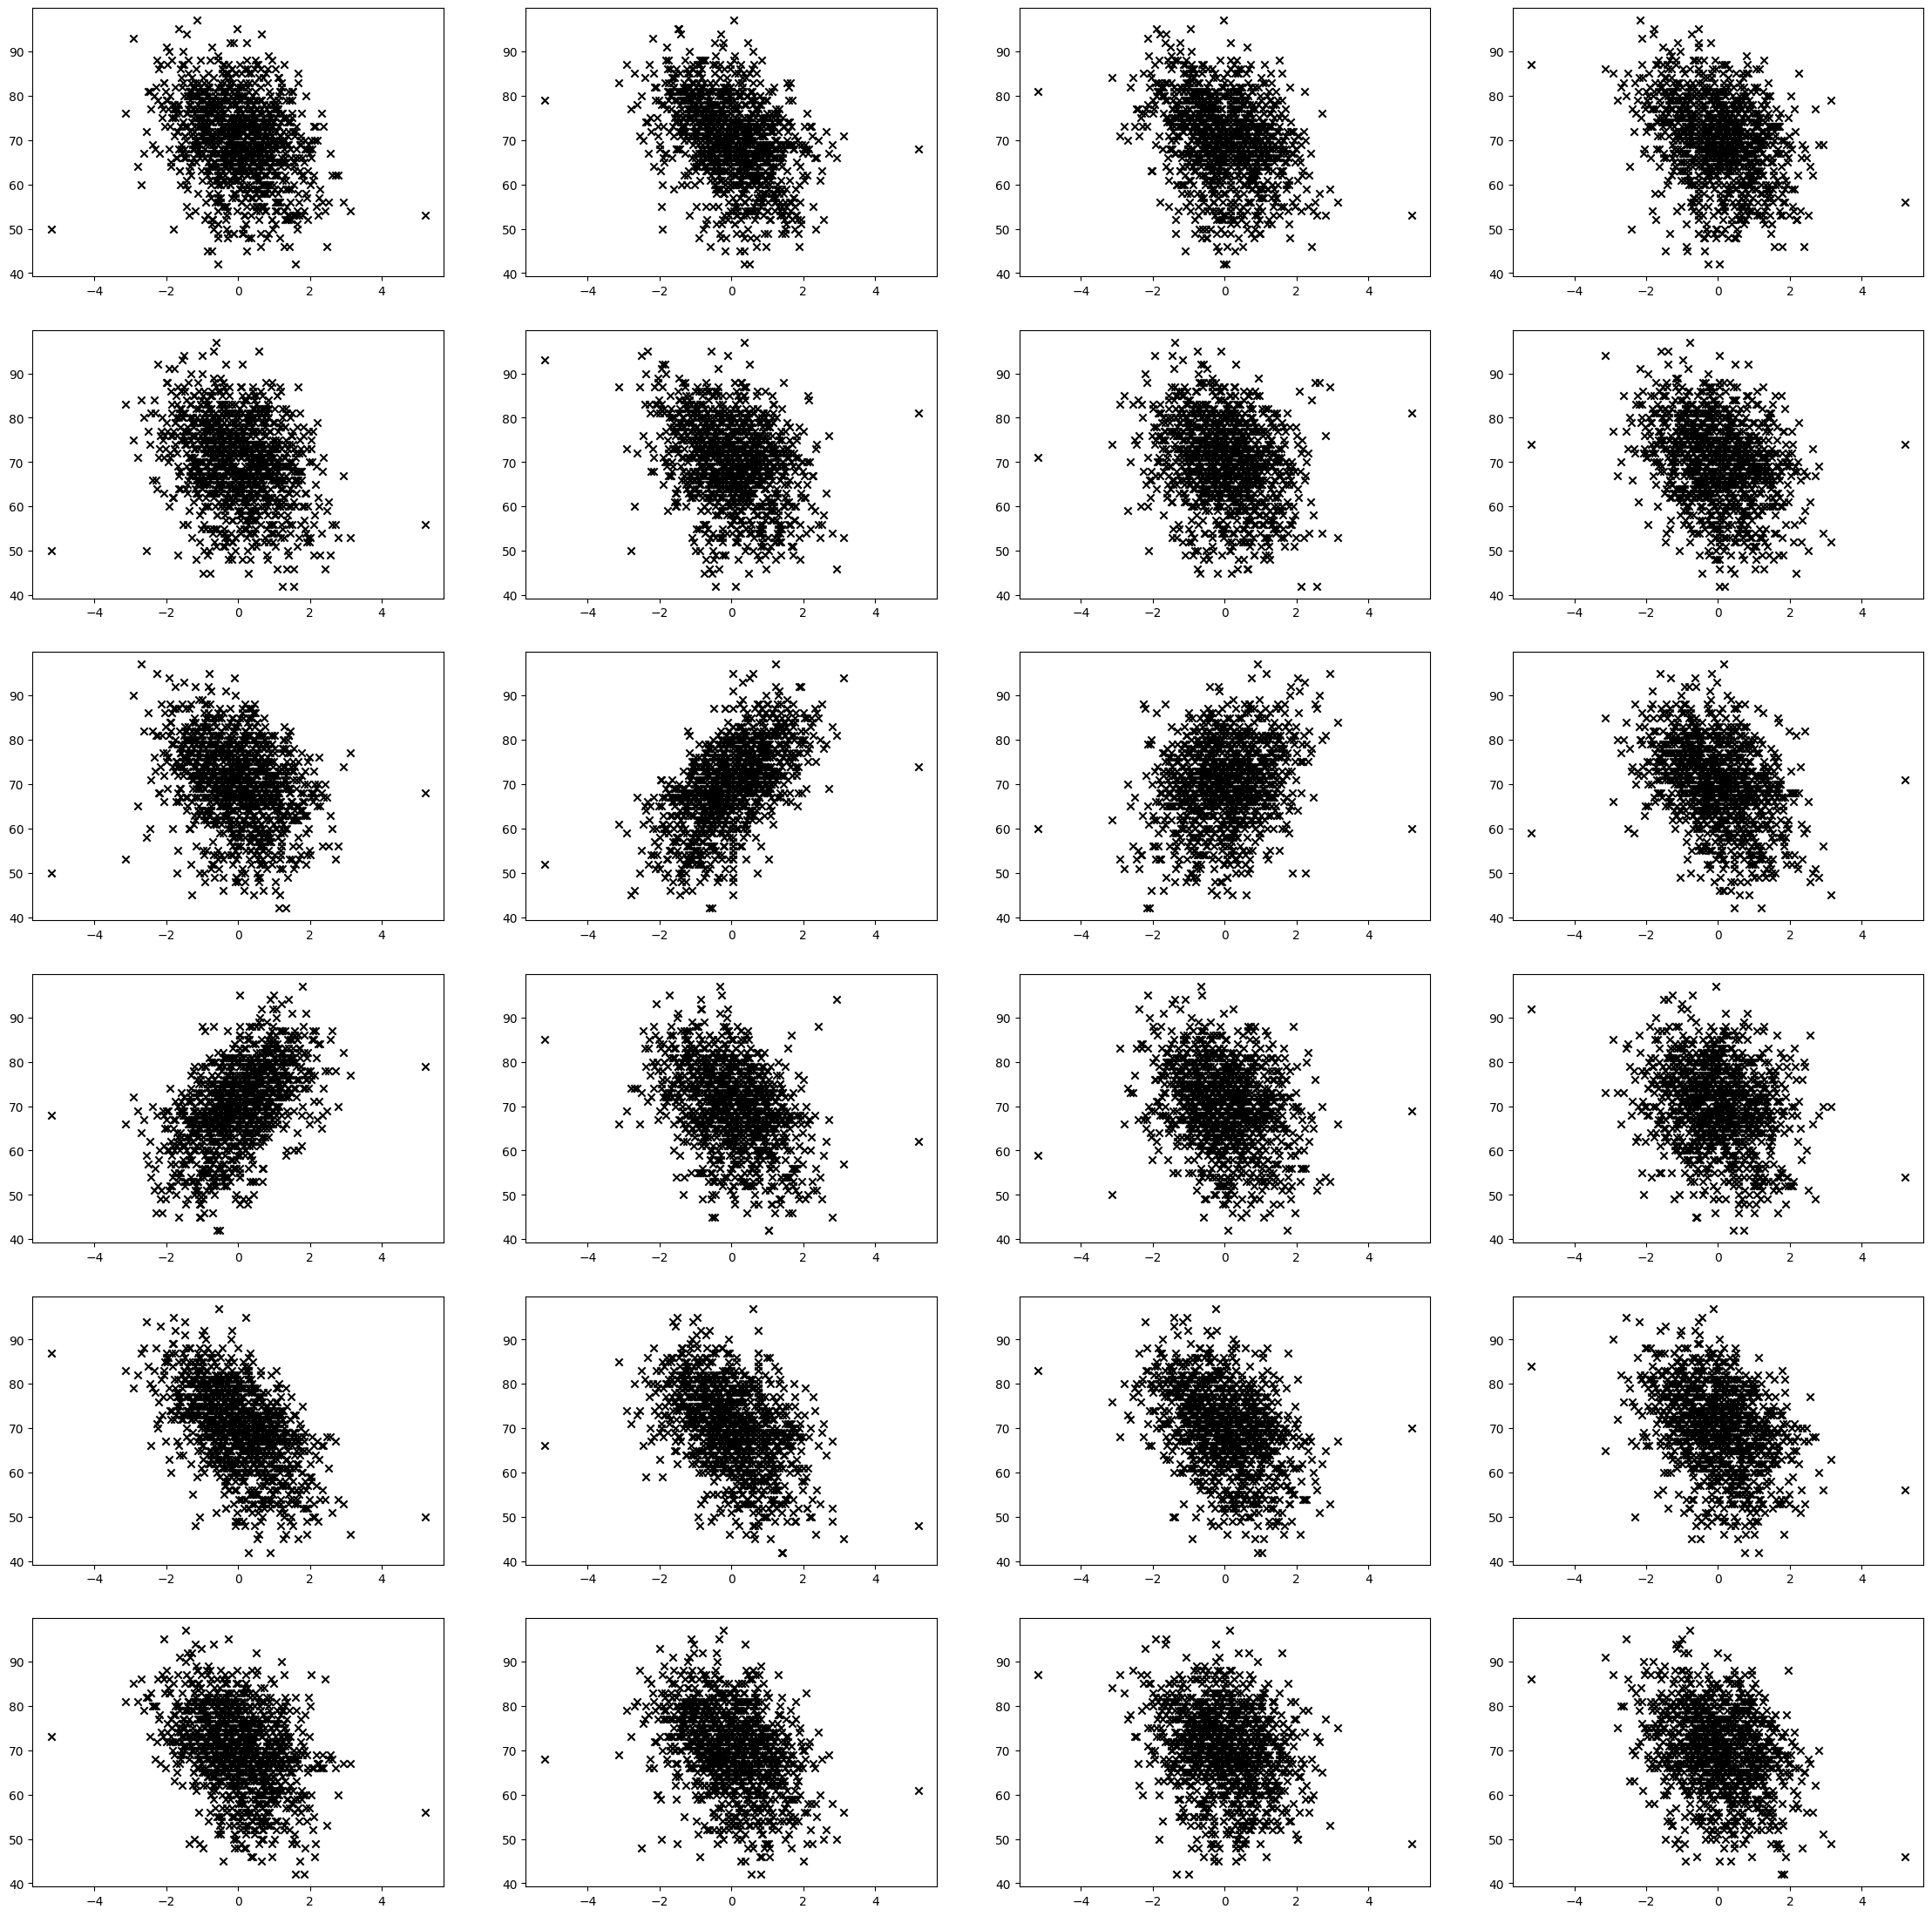

In [20]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(28, 28))

for i in range(24):
    ax[i // 4, i % 4].scatter(X.iloc[:, i], y, marker='x',color='black')
plt.show()

From the observations above we notice that some of the data is heavily skewed
Which implies that we might need to perform a quantile transform and not just a simple robust median centering/IQR scalign.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
assert X_train.shape[1] == X_test.shape[1]
nb_features = X_train.shape[1]

In [ ]:
nb_features // 10

2

In [ ]:
# PyTorch MLP
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.mps.is_available()
    else "cpu"
)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = [
            torch.nn.Linear(nb_features, nb_features // 2, dtype=torch.float32),
            torch.nn.SELU(),
            torch.nn.Linear(nb_features // 2, nb_features // 4, dtype=torch.float32),
            torch.nn.SELU(),
            torch.nn.Linear(nb_features // 4, nb_features // 6, dtype=torch.float32),
            torch.nn.SELU(),
            torch.nn.Linear(nb_features // 6, nb_features // 8, dtype=torch.float32),
            torch.nn.SELU(),
            torch.nn.Linear(nb_features // 8, nb_features // 10, dtype=torch.float32),
            torch.nn.SELU(),
            torch.nn.Linear(nb_features // 10, 1, dtype=torch.float32)
        ]
        self.f = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.f(x)

model = MLP().to(device)
print(model)


MLP(
  (f): Sequential(
    (0): Linear(in_features=137, out_features=68, bias=True)
    (1): SELU()
    (2): Linear(in_features=68, out_features=34, bias=True)
    (3): SELU()
    (4): Linear(in_features=34, out_features=22, bias=True)
    (5): SELU()
    (6): Linear(in_features=22, out_features=17, bias=True)
    (7): SELU()
    (8): Linear(in_features=17, out_features=13, bias=True)
    (9): SELU()
    (10): Linear(in_features=13, out_features=1, bias=True)
  )
)


In [ ]:
from torch.nn import MSELoss, L1Loss

loss_fn = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # zero out all gradients
        optimizer.zero_grad()

        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = .0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= len(dataloader)
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 5045.363770  [   32/  956]
Test Error: Avg loss: 246.772591 

Epoch 2
-------------------------------
loss: 237.860016  [   32/  956]
Test Error: Avg loss: 81.260708 

Epoch 3
-------------------------------
loss: 46.021484  [   32/  956]
Test Error: Avg loss: 51.402353 

Epoch 4
-------------------------------
loss: 38.282894  [   32/  956]
Test Error: Avg loss: 49.235181 

Epoch 5
-------------------------------
loss: 25.917110  [   32/  956]
Test Error: Avg loss: 48.741139 

Epoch 6
-------------------------------
loss: 23.410631  [   32/  956]
Test Error: Avg loss: 49.780653 

Epoch 7
-------------------------------
loss: 22.594038  [   32/  956]
Test Error: Avg loss: 52.250023 

Epoch 8
-------------------------------
loss: 22.238987  [   32/  956]
Test Error: Avg loss: 53.359872 

Epoch 9
-------------------------------
loss: 21.418804  [   32/  956]
Test Error: Avg loss: 54.258093 

Epoch 10
-------------------------------
loss: 20.3

In [ ]:
from sklearn.metrics import r2_score

model.eval()

with torch.no_grad():
    print(r2_score(y_test, model(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy()))

0.28558552265167236


In [23]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 22.3 MB/s eta 0:00:00


In [33]:
import torch
import gpytorch
import gpytorch.constraints
from torch.optim import Adam

# train_x, train_y = torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values.squeeze(), dtype=torch.float32)
# test_x, test_y = torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values.squeeze(), dtype=torch.float32)
train_x_real, train_y_real = torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values.squeeze(), dtype=torch.float32)



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()) \
         + gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel()) + \
          gpytorch.kernels.ScaleKernel(gpytorch.kernels.ConstantKernel()) + gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = ExactGPModel(train_x_real, train_y_real, likelihood)

training_iter = 300
# search for optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = Adam(gp_model.parameters(), lr=0.1)

# Loss for gps
mll = gpytorch.mlls.LeaveOneOutPseudoLikelihood(likelihood, gp_model)

for i in range(training_iter):
    optimizer.zero_grad()

    output = gp_model(train_x_real)

    loss = -mll(output, train_y_real)

    loss.backward()

    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item(),
    ))

    optimizer.step()


Iter 1/300 - Loss: 9.002
Iter 2/300 - Loss: 8.503
Iter 3/300 - Loss: 8.052
Iter 4/300 - Loss: 7.645
Iter 5/300 - Loss: 7.277
Iter 6/300 - Loss: 6.946
Iter 7/300 - Loss: 6.647
Iter 8/300 - Loss: 6.377
Iter 9/300 - Loss: 6.134
Iter 10/300 - Loss: 5.914
Iter 11/300 - Loss: 5.716
Iter 12/300 - Loss: 5.537
Iter 13/300 - Loss: 5.375
Iter 14/300 - Loss: 5.230
Iter 15/300 - Loss: 5.099
Iter 16/300 - Loss: 4.982
Iter 17/300 - Loss: 4.876
Iter 18/300 - Loss: 4.780
Iter 19/300 - Loss: 4.691
Iter 20/300 - Loss: 4.608
Iter 21/300 - Loss: 4.530
Iter 22/300 - Loss: 4.456
Iter 23/300 - Loss: 4.387
Iter 24/300 - Loss: 4.323
Iter 25/300 - Loss: 4.262
Iter 26/300 - Loss: 4.206
Iter 27/300 - Loss: 4.154
Iter 28/300 - Loss: 4.106
Iter 29/300 - Loss: 4.061
Iter 30/300 - Loss: 4.019
Iter 31/300 - Loss: 3.980
Iter 32/300 - Loss: 3.943
Iter 33/300 - Loss: 3.910
Iter 34/300 - Loss: 3.879
Iter 35/300 - Loss: 3.850
Iter 36/300 - Loss: 3.823
Iter 37/300 - Loss: 3.799
Iter 38/300 - Loss: 3.776
Iter 39/300 - Loss: 3

In [34]:
X_test = pd.read_csv('task-1-brain-age-prediction/X_test.csv')
X_test_id = X_test['id']
X_test.drop(columns=['id'], inplace=True)
X_test = knn_impute.transform(X_test)
X_test = X_test[:, mask_]
X_test = qtr.transform(X_test)

X_test = X_test[:, feature_corr]
X_test = X_test[:, mask_multicorr]

test_x_real = torch.tensor(X_test, dtype=torch.float32)

gp_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred = likelihood(gp_model(test_x_real))

    # Create a submission file
    submission = pd.DataFrame({'id': X_test_id, 'y': pred.mean})
    submission.to_csv('gpytorch_submission.csv', index=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
